<a href="https://colab.research.google.com/github/Shubhranshu-Malhotra/Tensorflow-Developer-ZTM/blob/main/%5BPractice%5D_05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous section, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Now we're going to cover another type of transfer learning: fine-tuning.

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

**Model we will use:** This time we will use models within `tf.keras.applications` and apply them to our own problem. (recognizing food images)


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!nvidia-smi

Thu May 27 11:55:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

🟢 [Important] 🔽
Throughout your machine learning experiments, you'll likely come across snippets of code you want to use over and over again.

For example, a plotting function which plots a model's `history` object (see `plot_loss_curves()` below).

You could recreate these functions over and over again.

But as you might've guessed, rewritting the same functions becomes tedious.

One of the solutions is to store them in a helper script such as [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py). And then import the necesary functionality when you need it.

For example, you might write:

```
from helper_functions import plot_loss_curves

...

plot_loss_curves(history)
```

Let's see what this looks like.

In [3]:
!wget https://raw.githubusercontent.com/Shubhranshu-Malhotra/Tensorflow-Developer-ZTM/main/tensorflow-deep-learning/extras/helper_functions.py

--2021-05-27 11:55:29--  https://raw.githubusercontent.com/Shubhranshu-Malhotra/Tensorflow-Developer-ZTM/main/tensorflow-deep-learning/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-05-27 11:55:29 (112 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# import helper function we will use in this script 🟢 [Important] 🔽
from helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir, unzip_data

## Get the data

In [5]:
# download and unzip our 10% 10 classes food data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2021-05-27 11:55:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 2607:f8b0:4023:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   258MB/s    in 0.6s    

2021-05-27 11:55:30 (258 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [7]:
# Set up train and test paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


### To load data
🟢 [Important] 🔽   
This time we won't use `ImageDataGenerator`.  
We will use `image_dataset_from_directory()`  
Why?   
`image_dataset_from_directory()` loads data in `tf.data.Dataset` format which is much more handy and is faster.   

In [8]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

In [9]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, 
                                                                            image_size=IMAGE_SIZE, 
                                                                            label_mode = 'categorical', 
                                                                            batch_size = BATCH_SIZE)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir, 
                                                                            image_size=IMAGE_SIZE, 
                                                                            label_mode = 'categorical', 
                                                                            batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [11]:
# Check class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [12]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[7.60758896e+01 3.90758934e+01 1.20758924e+01]
   [8.14027481e+01 4.44027443e+01 1.74027424e+01]
   [8.27410736e+01 4.57410736e+01 1.67410717e+01]
   ...
   [5.87366066e+01 2.37366066e+01 4.73660707e+00]
   [5.87366066e+01 2.37366066e+01 4.73660707e+00]
   [5.87366066e+01 2.37366066e+01 4.73660707e+00]]

  [[7.98660736e+01 4.28660698e+01 1.58660717e+01]
   [8.44524918e+01 4.74524879e+01 2.04524879e+01]
   [8.57946472e+01 4.87946434e+01 1.97946434e+01]
   ...
   [5.80000000e+01 2.30000000e+01 4.00000000e+00]
   [5.80000000e+01 2.30000000e+01 4.00000000e+00]
   [5.80000000e+01 2.30000000e+01 4.00000000e+00]]

  [[7.99196396e+01 4.19687500e+01 1.52857141e+01]
   [8.41967545e+01 4.62458572e+01 1.95628185e+01]
   [8.53169632e+01 4.76830368e+01 1.86830349e+01]
   ...
   [5.70000000e+01 2.20000000e+01 3.00000000e+00]
   [5.70000000e+01 2.20000000e+01 3.00000000e+00]
   [5.70000000e+01 2.20000000e+01 3.00000000e+00]]

  ...

  [[7.00000000e+00 3.00000000e+00 0.00000000e+00]
   [7

In [13]:
tf.reduce_max(images[0]), tf.reduce_min(images[0])

(<tf.Tensor: shape=(), dtype=float32, numpy=254.9496>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)

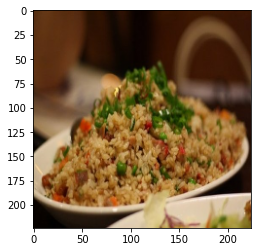

In [14]:
plt.imshow(images[0]/255.)

## Model 0: Creating a transfer learning feature extraction model using functional api


In [15]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the weights of base model so that weights are not updated during training
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224,224,3), name = 'input_layer')

# 4. If using ResnNet50V2 you will need to normalize inputs [Not required for efficientnet] (optional)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to base_model
x = base_model(inputs)
print(f"Shape after passing inputs to the base model: {x.shape}")

# 6. Average pool the outputs of the base_model (aggregate all the most important info, reduce number of parameters)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# 8. Combine the inputs with outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# 10. Fit the model
model_0_history = model_0.fit(train_data_10_percent,
                              epochs = 5,
                              steps_per_epoch = len(train_data_10_percent),
                              validation_data = test_data_10_percent,
                              validation_steps = int(0.25 * len(test_data_10_percent)),
                              callbacks = [create_tensorboard_callback(
                                            dir_name = "/content/drive/MyDrive/Food_Classification/tensorboard",
                                            experiment_name = "05_model_0_10_percent_feature_extraction")])

16711680/16705208 [==============================] - 0s 0us/step
Shape after passing inputs to the base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D (None, 1280)
Saving TensorBoard log files to: /content/drive/MyDrive/Food_Classification/tensorboard/05_model_0_10_percent_feature_extraction/20210527-115541


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
24/24 [==============================] - 41s 297ms/step - loss: 1.9089 - accuracy: 0.3973 - val_loss: 1.3188 - val_accuracy: 0.7270
Epoch 2/5
24/24 [==============================] - 5s 193ms/step - loss: 1.1360 - accuracy: 0.7533 - val_loss: 0.8799 - val_accuracy: 0.8076
Epoch 3/5
24/24 [==============================] - 5s 191ms/step - loss: 0.8369 - accuracy: 0.8213 - val_loss: 0.7118 - val_accuracy: 0.8438
Epoch 4/5
24/24 [==============================] - 5s 202ms/step - loss: 0.6775 - accuracy: 0.8560 - val_loss: 0.6192 - val_accuracy: 0.8569
Epoch 5/5
24/24 [==============================] - 5s 192ms/step - loss: 0.5845 - accuracy: 0.8680 - val_loss: 0.5799 - val_accuracy: 0.8536


In [16]:
# Evaluate of the full test data
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 9s 107ms/step - loss: 0.6020 - accuracy: 0.8388


[0.6020199060440063, 0.8388000130653381]

In [17]:
# Check the layers in out base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [18]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [19]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

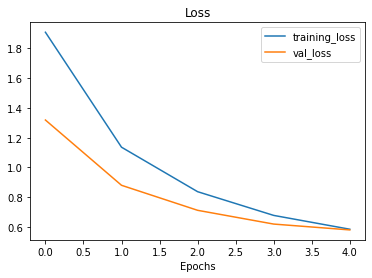

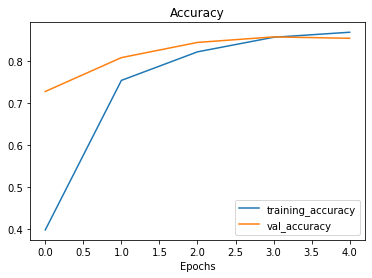

In [20]:
# Check out our model's training curves
plot_loss_curves(model_0_history)